# Experiment: Baseline
**Beschrijving:** Een baseline opzetten van het nieuwe soort model om specifieke spectrogrammen na te maken.,

**Datum:** 21 mei 2025

**Auteur:** Paul

**Versie:** V0.1

**Status:** Progress

## Doel en Verwachtingen
**Doelstelling:** Duidelijke weten wat de input is van het model, hoe de preprocessing werkt en wat de output van het model is.

**Verwachting:** Meer duidelijkheid en structuur hoe het werkt.

## Data en Bronnen
**Datasets:**
- N.v.t. dataset is lokaal opgenomen

**Externe Bronnen:**
- N.v.t.

## Software Configuratie
**Software:**

In [1]:
# Data Manipulation and Analysis
import pandas as pd # type: ignore
import numpy as np # type: ignore
import librosa

# Machine Learning and Data Preprocessing
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Conv2DTranspose, Flatten, Reshape # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.losses import mse # type: ignore
import tensorflow.keras.backend as K # type: ignore
import tensorflow as tf # type: ignore
# Visualization
import matplotlib.pyplot as plt # type: ignore

# System and File Management
import sounddevice as sd # type: ignore
import sys
import os
import time
import soundfile as sf
from IPython.display import clear_output, display
from datetime import datetime
import re

# Add a path to the scripts directory
sys.path.append(os.path.abspath(os.path.join('../../', 'scripts')))

# Project-Specific Modules
from RetrievingData import load_dataframe, load_dataset # type: ignore
from AnalysisPlots import plot_label_distribution # type: ignore
from ProcessingData import process_audio # type: ignore

## Business Understanding
**Doel:** Een model dat werkt op basis van data dat als normaal wordt geschouwd in een specifieke context.

**Succescriterium:** Een model dat werkt met normale data.

## Data Understanding
**Datasets:** Zelf opgenomen data van mijn kantoor thuis.

In [2]:
def extract_spectrogram(segment, sample_rate=44100, n_fft=678, hop_length=256):
    """
    Compute the log-amplitude spectrogram (dB scale) of an audio segment using STFT.

    Args:
        segment (np.ndarray): 1D audio array (mono).
        sample_rate (int): Sampling rate of the audio in Hz.
        n_fft (int, optional): FFT window size.
        hop_length (int, optional): Number of samples between frames.

    Returns:
        np.ndarray: 2D log-amplitude spectrogram (dB scale).
    """
    segment = segment.astype(np.float32)
    stft = librosa.stft(segment, n_fft=n_fft, hop_length=hop_length)
    spec_db = librosa.amplitude_to_db(np.abs(stft))
    return spec_db

def record_audio_segments(
    duration_sec=300,
    segment_sec=10,
    sample_rate=44100,
    description="opname",
    output_dir="data",
    on_segment_recorded=None
):
    """
    Record audio in segments and optionally apply a callback per segment.

    This function records audio using the system microphone, splits it into fixed-length
    segments, and optionally performs an action (e.g. plotting, logging, inference) via
    the `on_segment_recorded` callback after each segment. The final recording is saved
    as a single WAV file.

    Args:
        duration_sec (int): Total duration of the recording in seconds. Defaults to 300.
        segment_sec (int): Duration of each segment in seconds. Defaults to 10.
        sample_rate (int): Sampling rate in Hz. Defaults to 44100.
        description (str): Optional description used in the output filename. Defaults to "opname".
        output_dir (str): Directory where the WAV file will be saved. Defaults to "data".
        on_segment_recorded (Callable[[np.ndarray, int]], optional): 
            Callback function to be called after each segment is recorded.
            Receives the segment (1D np.ndarray) and the segment index as arguments.

    Returns:
        Tuple[List[np.ndarray], int, np.ndarray]: A tuple containing:
            - A list of recorded segments (each a 1D float32 numpy array),
            - The sample rate used (int),
            - The full concatenated audio signal as a 1D float32 numpy array.
    """

    def sanitize(text: str) -> str:
        return re.sub(r'[^A-Za-z0-9_-]', '_', text).strip('_')

    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f"{timestamp}_{sanitize(description)}.wav"
    filepath = os.path.join(output_dir, filename)

    n_segments = duration_sec // segment_sec
    samples_per_segment = segment_sec * sample_rate
    segments = []

    with sd.InputStream(samplerate=sample_rate, channels=1) as stream:
        stream.read(sample_rate)  # pre-roll
        for i in range(n_segments):
            segment, _ = stream.read(samples_per_segment)
            segment = segment.flatten()
            segments.append(segment)
            if on_segment_recorded:
                on_segment_recorded(segment, i)

    full_audio = np.concatenate(segments)
    sf.write(filepath, full_audio, sample_rate)
    print(f"Opname opgeslagen als: {filepath}")

def make_live_plot_callback(feature_fn, y_axis='log'):
    """
    Returns a callback function that generates a live plot for a single feature 
    (e.g., spectrogram, mel spectrogram, MFCC) during audio recording.

    Args:
        feature_fn (Callable[[np.ndarray, int], np.ndarray]): 
            Feature extraction function. Should take a 1D segment and sample rate, and return a 2D array.
        y_axis (str, optional): 
            Y-axis type for librosa's `specshow`, e.g., 'log', 'mel', or None. Defaults to 'log'.

    Returns:
        Callable[[np.ndarray, int], None]: 
            A function that can be passed as `on_segment_recorded` to `record_audio_segments`, 
            which will plot the feature in real time during recording.
    """
    def live_plot(segment, i):
        sr = 44100
        hop_length = 256
        clear_output(wait=True)
        plt.figure(figsize=(10, 4))
        features = feature_fn(segment, sr)
        librosa.display.specshow(
            features,
            sr=sr,
            hop_length=hop_length,
            x_axis='time',
            y_axis=y_axis,
            cmap='magma'
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Spectrogram segment {i+1}")
        plt.tight_layout()
        display(plt.gcf())
        plt.close()
    return live_plot

def record_and_plot_during_recording(feature_fn=extract_spectrogram, **kwargs):
    """
    Record audio and visualize a single feature live per segment using a specified feature extractor.

    This is a convenience wrapper around `record_audio_segments()` for quick visualization of 
    a single feature (e.g., spectrogram, mel spectrogram, MFCC). If you need multiple features, 
    use `record_and_plot_custom_features()` instead.

    Args:
        feature_fn (Callable[[np.ndarray, int], np.ndarray]): 
            Feature extraction function to apply per segment.
        **kwargs: 
            Additional arguments passed to `record_audio_segments` (e.g., duration_sec, segment_sec, sample_rate, etc.).

    Returns:
        Tuple[List[np.ndarray], int, np.ndarray]: 
            - List of audio segments
            - Sample rate
            - Full concatenated audio signal
    """
    live_plot_callback = make_live_plot_callback(feature_fn)
    return record_audio_segments(on_segment_recorded=live_plot_callback, **kwargs)

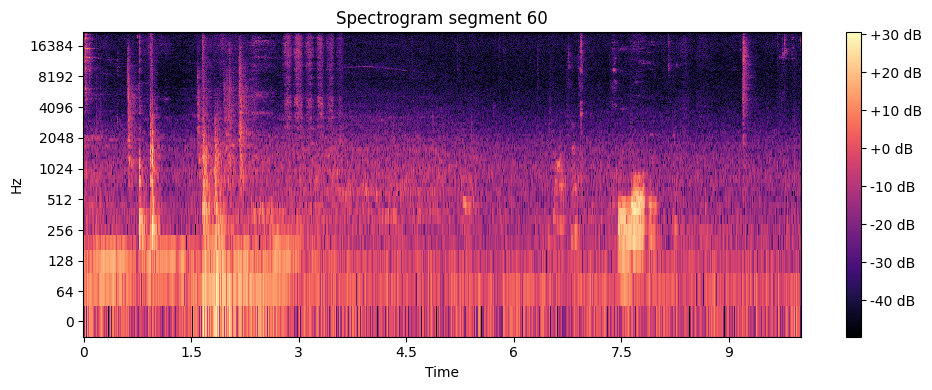

Opname opgeslagen als: data/test\20250715_093537_spectrogram_example.wav


In [3]:
record_and_plot_during_recording(
    feature_fn=extract_spectrogram,
    duration_sec=600,
    output_dir="data/test",
    description="spectrogram_example",
)

In [3]:
def plot_spectrogram(spec, sample_rate, hop_length, title, save_path=None, y_axis='linear'):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spec, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis=y_axis)
    plt.title(title)
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Spectrogram opgeslagen: {save_path}")
    plt.close()

def segment_audio(file_path, segment_length_sec, overlap_sec=0, output_dir="segments"):
    """
    Segmenteer audio in stukken van vaste lengte met optionele overlap en sla elk segment op als .wav.
    Bestandsnamen zijn gebaseerd op de originele naam met segmentnummer toegevoegd.
    """
    # Bestandsnaam zonder extensie
    base_name = os.path.splitext(os.path.basename(file_path))[0]

    # Audio inladen
    y, sr = librosa.load(file_path, sr=None)
    segment_samples = int(segment_length_sec * sr)
    overlap_samples = int(overlap_sec * sr)
    step = segment_samples - overlap_samples

    if step <= 0:
        raise ValueError("Overlap moet kleiner zijn dan segmentlengte.")

    os.makedirs(output_dir, exist_ok=True)
    segments = []

    for i, start in enumerate(range(0, len(y) - segment_samples + 1, step)):
        end = start + segment_samples
        segment = y[start:end]
        segments.append(segment)

        filename = f"{base_name}_segment_{i:03d}.wav"
        path = os.path.join(output_dir, filename)
        sf.write(path, segment, sr)

    print(f"{len(segments)} segmenten opgeslagen in '{output_dir}'")
    return segments, sr

In [4]:
segments, sr = segment_audio(
    file_path="data/test/20250715_093537_spectrogram_example.wav",
    segment_length_sec=2.0,
    overlap_sec=0.5,
    output_dir="data/demo"
)

399 segmenten opgeslagen in 'data/demo'


In [65]:
desired_labels = ['test_segments']
df, label_mapping = load_dataframe('data', desired_labels)

df

,file_path,label,label_numerical
0,data\test_segments\20250707_104843_spectrogram...,test_segments,0
1,data\test_segments\20250707_104843_spectrogram...,test_segments,0
2,data\test_segments\20250707_104843_spectrogram...,test_segments,0
3,data\test_segments\20250707_104843_spectrogram...,test_segments,0
4,data\test_segments\20250707_104843_spectrogram...,test_segments,0
...,...,...,...
1006,data\test_segments\20250715_093537_spectrogram...,test_segments,0
1007,data\test_segments\20250715_093537_spectrogram...,test_segments,0
1008,data\test_segments\20250715_093537_spectrogram...,test_segments,0
1009,data\test_segments\20250715_093537_spectrogram...,test_segments,0


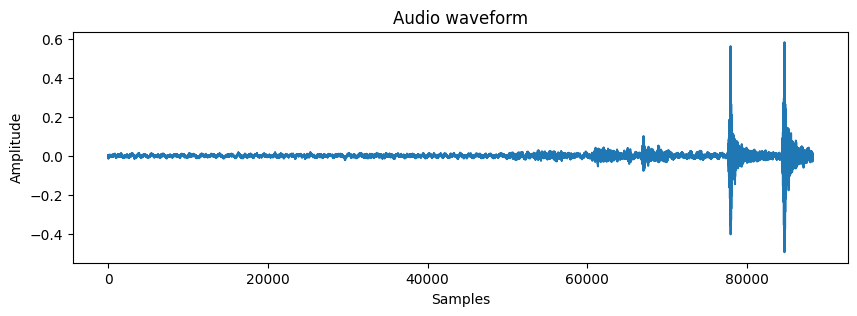

In [66]:
# Inladen data
y, sr = librosa.load(df.iloc[0]['file_path'], sr=44100)

# Plotten van de golfvorm
plt.figure(figsize=(10, 3))
plt.plot(y)
plt.title("Audio waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

📏 Lengte waveform: 2.00 seconden


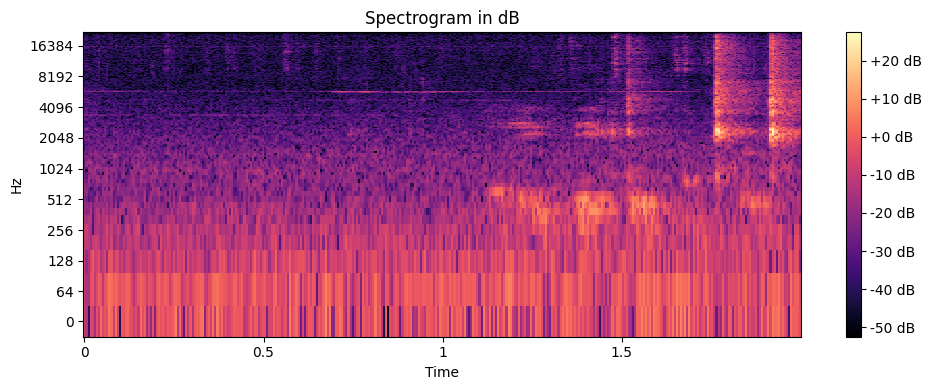

In [67]:
duration_sec = len(y) / sr
print(f"📏 Lengte waveform: {duration_sec:.2f} seconden")

# Extract spectrogram using the function
spec_db = extract_spectrogram(y, sr)

# Plot spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spec_db, sr=sr, hop_length=256,
                         x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram in dB")
plt.tight_layout()
plt.show()

## Data Preparation

In [161]:

class AudioProcessor:
    def __init__(self, n_fft=1024, hop_length=512, target_height=520, target_length=128):
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.target_height = target_height
        self.target_length = target_length
        self.bin_mean = None
        self.bin_std = None

    def compute_bin_stats(self, audio_list):
        spectrograms = []
        for audio in audio_list:
            stft = librosa.stft(audio, n_fft=self.n_fft, hop_length=self.hop_length)
            magnitude_db = librosa.amplitude_to_db(np.abs(stft), ref=1.0)
            spectrograms.append(magnitude_db)
        stacked = np.concatenate(spectrograms, axis=1)
        self.bin_mean = np.mean(stacked, axis=1, keepdims=True)
        self.bin_std = np.std(stacked, axis=1, keepdims=True) + 1e-8

    def save_stats(self, path="bin_stats"):
        os.makedirs(path, exist_ok=True)
        np.save(os.path.join(path, "bin_mean.npy"), self.bin_mean)
        np.save(os.path.join(path, "bin_std.npy"), self.bin_std)

    def load_stats(self, path="bin_stats"):
        self.bin_mean = np.load(os.path.join(path, "bin_mean.npy"), allow_pickle=True)
        self.bin_std  = np.load(os.path.join(path, "bin_std.npy"), allow_pickle=True)

    def audio_to_specto(self, audio):
        if self.bin_mean is None or self.bin_std is None:
            raise RuntimeError("Je moet eerst compute_bin_stats() of load_stats() aanroepen.")
        stft = librosa.stft(audio, n_fft=self.n_fft, hop_length=self.hop_length)
        magnitude_db = librosa.amplitude_to_db(np.abs(stft), ref=1.0)
        norm_spec = (magnitude_db - self.bin_mean) / self.bin_std
        h, w = norm_spec.shape
        if h < self.target_height:
            norm_spec = np.pad(norm_spec, ((0, self.target_height - h), (0, 0)), mode='constant')
        else:
            norm_spec = norm_spec[:self.target_height, :]
        if w < self.target_length:
            norm_spec = np.pad(norm_spec, ((0, 0), (0, self.target_length - w)), mode='constant')
        else:
            norm_spec = norm_spec[:, :self.target_length]
        return norm_spec[..., np.newaxis]

    def process_audio_live(self, segment_samples):
        samples_np = np.array(segment_samples).astype(np.float32)
        max_val = np.max(np.abs(samples_np))
        if max_val > 0:
            samples_np = samples_np / max_val
        spec = self.audio_to_specto(samples_np)
        return np.expand_dims(spec, axis=0)  # batch dim: (1, 520, 128, 1)

In [150]:
from sklearn.model_selection import train_test_split

audio_list = [
    librosa.load(row['file_path'], sr=None)[0]
    for _, row in df.iterrows()
]

# Split in train/test
audio_train, audio_test = train_test_split(audio_list, test_size=0.2, random_state=42)

# ===== Stap 2: AudioProcessor aanroepen =====
audio_processor = AudioProcessor()
audio_processor.compute_bin_stats(audio_train)

X_train = np.array([audio_processor.audio_to_specto(audio) for audio in audio_train])
X_test  = np.array([audio_processor.audio_to_specto(audio) for audio in audio_test])

[DEBUG] audio shape: (88200,), dtype: float32
[DEBUG] STFT shape: (513, 173)
[DEBUG] magnitude_db shape: (513, 173)
[DEBUG] bin_mean shape: (513, 1), dtype: float32
[DEBUG] audio shape: (88200,), dtype: float32
[DEBUG] STFT shape: (513, 173)
[DEBUG] magnitude_db shape: (513, 173)
[DEBUG] bin_mean shape: (513, 1), dtype: float32
[DEBUG] audio shape: (88200,), dtype: float32
[DEBUG] STFT shape: (513, 173)
[DEBUG] magnitude_db shape: (513, 173)
[DEBUG] bin_mean shape: (513, 1), dtype: float32
[DEBUG] audio shape: (88200,), dtype: float32
[DEBUG] STFT shape: (513, 173)
[DEBUG] magnitude_db shape: (513, 173)
[DEBUG] bin_mean shape: (513, 1), dtype: float32
[DEBUG] audio shape: (88200,), dtype: float32
[DEBUG] STFT shape: (513, 173)
[DEBUG] magnitude_db shape: (513, 173)
[DEBUG] bin_mean shape: (513, 1), dtype: float32
[DEBUG] audio shape: (88200,), dtype: float32
[DEBUG] STFT shape: (513, 173)
[DEBUG] magnitude_db shape: (513, 173)
[DEBUG] bin_mean shape: (513, 1), dtype: float32
[DEBUG] au

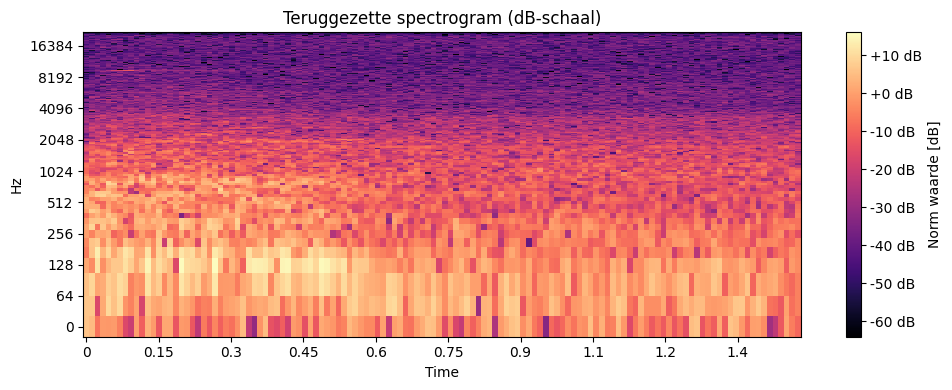

In [151]:
# Kies 1 spectrogram uit je dataset
spec = X_train[0]  # shape: (520, 128, 1)

# Verwijder kanaaldimensie
if spec.ndim == 3:
    spec = spec[:, :, 0]

# Alleen de originele 513 frequency bins de-normaliseren
n_bins = audio_processor.bin_mean.shape[0]  # = 513
spec_db = np.zeros_like(spec)  # zelfde shape als (520, 128)
spec_db[:n_bins, :] = spec[:n_bins, :] * audio_processor.bin_std + audio_processor.bin_mean
# De overige gepadde rijen (513:520) blijven 0 (of kun je op -80 zetten)

# Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(spec_db,
                         sr=44100,
                         hop_length=audio_processor.hop_length,
                         x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format="%+2.0f dB", label="Norm waarde [dB]")
plt.title("Teruggezette spectrogram (dB-schaal)")
plt.tight_layout()
plt.show()

## Modeling

In [152]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Conv2D, DepthwiseConv2D, BatchNormalization,
    Conv2DTranspose, Dense, Flatten, Reshape, Cropping2D
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [153]:
input_shape = (520, 128, 1)

In [154]:
def build_outliernet(input_shape=(520, 128, 1),
                     latent_dim=40,
                     variant='alpha'):
    """
    Bouwt een convolutionele autoencoder:
      - variant='alpha': gebruikt DepthwiseConv2D + pointwise Conv2D
      - variant='beta' : alleen standaard Conv2D
    """
    assert variant in ('alpha', 'beta'), "variant moet 'alpha' of 'beta' zijn"

    # ===== Encoder =====
    inp = Input(shape=input_shape, name='encoder_input')
    x = inp

    filters = [8, 16, 32]
    for i, f in enumerate(filters):
        if variant == 'alpha':
            x = DepthwiseConv2D(3, strides=2, padding='same',
                                name=f'dw_conv_{i}')(x)
            x = BatchNormalization(name=f'dw_bn_{i}')(x)
            x = Conv2D(f, 1, padding='same', name=f'pw_conv_{i}')(x)
        else:
            x = Conv2D(f, 3, strides=2, padding='same',
                       name=f'conv_{i}')(x)
        x = BatchNormalization(name=f'bn_{i}')(x)
        x = tf.keras.activations.relu(x)

    # bepaal static shape vóór flatten
    shape_before_flatten = K.int_shape(x)[1:]  # tuple, bv. (4, 16, 32)
    flat_dim = int(np.prod(shape_before_flatten))

    # Flatten + latent dense
    x = Flatten(name='flatten')(x)
    latent = Dense(latent_dim, name='latent_dense')(x)

    # ===== Decoder =====
    x = Dense(flat_dim, name='decoder_dense')(latent)
    x = Reshape(shape_before_flatten, name='reshape')(x)

    for i, f in enumerate(reversed(filters)):
        x = Conv2DTranspose(f, 3, strides=2, padding='same',
                            name=f'deconv_{i}')(x)
        x = BatchNormalization(name=f'de_bn_{i}')(x)
        x = tf.keras.activations.relu(x)

    x = Conv2DTranspose(input_shape[2], 3, padding='same',
                    name='decoder_output')(x)

    out = x
    
    return Model(inputs=inp, outputs=out,
                 name=f'OutlierNet_{variant}')

In [155]:
def reconstruction_error(x, x_recon):
    """
    Bereken per-voorbeeld de MSE reconstructiefout:
      Hoge fout → anomalie
    """
    # x, x_recon shape = (batch, 32, 128, 1)
    err = tf.reduce_mean(tf.math.squared_difference(x, x_recon),
                         axis=[1,2,3])
    return err

In [139]:
if __name__ == "__main__":
    for variant in ('alpha', 'beta'):
        model = build_outliernet(variant=variant)
        print(f"\n===== Model summary ({variant}) =====")
        model.summary()


===== Model summary (alpha) =====


Model: "OutlierNet_alpha"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 520, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_conv_0 (DepthwiseConv2D)     │ (None, 260, 64, 1)     │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_bn_0 (BatchNormalization)    │ (None, 260, 64, 1)     │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pw_conv_0 (Conv2D)              │ (None, 260, 64, 8)     │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_0 (BatchNormalization)       │ (None, 260, 64, 8)     │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_156 (ReLU)                │ (None, 260, 64, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_conv_1 (DepthwiseConv2D)     │ (None, 130, 32, 8)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_bn_1 (BatchNormalization)    │ (None, 130, 32, 8)     │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pw_conv_1 (Conv2D)              │ (None, 130, 32, 16)    │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 130, 32, 16)    │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_157 (ReLU)                │ (None, 130, 32, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_conv_2 (DepthwiseConv2D)     │ (None, 65, 16, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dw_bn_2 (BatchNormalization)    │ (None, 65, 16, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pw_conv_2 (Conv2D)              │ (None, 65, 16, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 65, 16, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_158 (ReLU)                │ (None, 65, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33280)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_dense (Dense)            │ (None, 40)             │     1,331,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense (Dense)           │ (None, 33280)          │     1,364,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 65, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv_0 (Conv2DTranspose)      │ (None, 130, 32, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ de_bn_0 (BatchNormalization)    │ (None, 130, 32, 32)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_159 (ReLU)                │ (None, 130, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv_1 (Conv2DTranspose)      │ (None, 260, 64, 16)    │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ de_bn_1 (BatchNormalization)    │ (None, 260, 64, 16)    │            6

 Total params: 2,712,327 (10.35 MB)

 Trainable params: 2,712,053 (10.35 MB)

 Non-trainable params: 274 (1.07 KB)


===== Model summary (beta) =====


Model: "OutlierNet_beta"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 520, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_0 (Conv2D)                 │ (None, 260, 64, 8)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_0 (BatchNormalization)       │ (None, 260, 64, 8)     │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_162 (ReLU)                │ (None, 260, 64, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 130, 32, 16)    │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 130, 32, 16)    │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_163 (ReLU)                │ (None, 130, 32, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 65, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 65, 16, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_164 (ReLU)                │ (None, 65, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33280)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_dense (Dense)            │ (None, 40)             │     1,331,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense (Dense)           │ (None, 33280)          │     1,364,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 65, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv_0 (Conv2DTranspose)      │ (None, 130, 32, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ de_bn_0 (BatchNormalization)    │ (None, 130, 32, 32)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_165 (ReLU)                │ (None, 130, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv_1 (Conv2DTranspose)      │ (None, 260, 64, 16)    │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ de_bn_1 (BatchNormalization)    │ (None, 260, 64, 16)    │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_166 (ReLU)                │ (None, 260, 64, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv_2 (Conv2DTranspose)      │ (None, 520, 128, 8)    │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ de_bn_2 (BatchNormalization)    │ (None, 520, 128, 8)    │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_167 (ReLU)                │ (None, 520, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 520, 128, 1)    │            73 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 2,717,161 (10.37 MB)

 Trainable params: 2,716,937 (10.36 MB)

 Non-trainable params: 224 (896.00 B)

In [140]:
input_shape = X_train.shape[1:]  # (520, 128, 1)
model = build_outliernet(input_shape=input_shape, latent_dim=256, variant='alpha')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

In [141]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_outliernet.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

In [142]:
history = model.fit(
    X_train, X_train,
    batch_size=32,
    epochs=50,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=callbacks
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 1.3398
Epoch 1: val_loss improved from inf to 1.03746, saving model to best_outliernet.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 335ms/step - loss: 1.3341 - val_loss: 1.0375
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 1.0005
Epoch 2: val_loss did not improve from 1.03746
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - loss: 0.9998 - val_loss: 1.0382
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.8717
Epoch 3: val_loss did not improve from 1.03746
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - loss: 0.8710 - val_loss: 1.0522
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.8470
Epoch 4: val_loss did not improve from 1.03746
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step - loss: 0.8459 - val_loss: 1.0909
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.8168
Epoch 5: val_loss did not improve from 1.03746
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - loss: 0.8161 - val_loss: 1.1606
Epoch 6/50
26/2

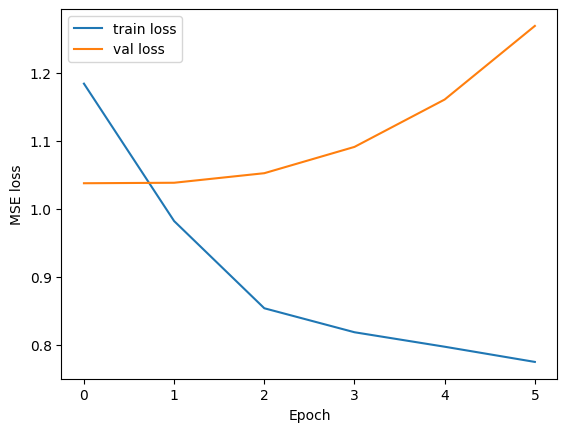

In [143]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.show()

In [144]:
audio_processor.save_stats("bin_stats")

## Evaluation

Het grootste probleem met deze aanpak is de evaluation van het model. Er zijn geen labels om te concluderen wat goed en fout is. Daarom is er voor gekozen om te kijken naar verschillende thresholds om vervolgens hier live meet te testen.

## Audio call back met opslag

In [156]:
# ===== Instellingen =====
sample_rate = 44100
segment_duration = 2  # seconden
threshold = 0.025
segment_samples = []
autoencoder = model

In [162]:
# ===== Callback functie =====
def audio_callback(indata, frames, time_info, status):
    global segment_samples

    if status:
        print(f"⚠️ Audiostatus: {status}")

    segment_samples.extend(indata[:, 0])

    if len(segment_samples) >= sample_rate * segment_duration:
        current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        print(f"\n📌 Voorspelling gestart om: {current_time}")

        segment = np.array(segment_samples[:sample_rate * segment_duration])
        audio_features = audio_processor.process_audio_live(segment)
        print(f"✅ Spectrogram shape (live): {audio_features.shape}")

        reconstructed_audio = autoencoder.predict(audio_features, verbose=0)
        mse = reconstruction_error(audio_features, reconstructed_audio)
        print(f"📊 Reconstructiefout (MSE): {float(mse):.5f}")

        if mse > threshold:
            print("🔴 Anomalie gedetecteerd!")
            os.makedirs("saved_spectrograms", exist_ok=True)
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            np.save(f"saved_spectrograms/original_{timestamp}.npy", audio_features[0, :, :, 0])
            np.save(f"saved_spectrograms/reconstructed_{timestamp}.npy", reconstructed_audio[0, :, :, 0])
            print(f"💾 Opgeslagen als: original_{timestamp}.npy & reconstructed_{timestamp}.npy")
        else:
            print("🟢 Normaal geluid.")

        segment_samples = []

In [163]:
# ===== Main loop =====
if __name__ == "__main__":
    # Init processor en model
    audio_processor = AudioProcessor()
    audio_processor.load_stats("bin_stats")  # Zorg dat deze folder en files bestaan

    print("bin_mean loaded:", audio_processor.bin_mean is not None)
    print("bin_std loaded:", audio_processor.bin_std is not None)

    autoencoder = model

    print("🎙️ Start audio streaming... Ctrl+C om te stoppen.")
    try:
        with sd.InputStream(callback=audio_callback,
                            channels=1,
                            samplerate=sample_rate):
            while True:
                sd.sleep(100)
    except KeyboardInterrupt:
        print("\n⏹️ Audio streaming gestopt.")

bin_mean loaded: True
bin_std loaded: True
🎙️ Start audio streaming... Ctrl+C om te stoppen.

📌 Voorspelling gestart om: 2025-07-15 14:28:50
✅ Spectrogram shape (live): (1, 520, 128, 1)
📊 Reconstructiefout (MSE): 9.39093
🔴 Anomalie gedetecteerd!
💾 Opgeslagen als: original_20250715_142851.npy & reconstructed_20250715_142851.npy

📌 Voorspelling gestart om: 2025-07-15 14:28:52
✅ Spectrogram shape (live): (1, 520, 128, 1)
📊 Reconstructiefout (MSE): 15.21241
🔴 Anomalie gedetecteerd!
💾 Opgeslagen als: original_20250715_142853.npy & reconstructed_20250715_142853.npy

📌 Voorspelling gestart om: 2025-07-15 14:28:54
✅ Spectrogram shape (live): (1, 520, 128, 1)
📊 Reconstructiefout (MSE): 2.42348
🔴 Anomalie gedetecteerd!
💾 Opgeslagen als: original_20250715_142855.npy & reconstructed_20250715_142855.npy

📌 Voorspelling gestart om: 2025-07-15 14:28:56
✅ Spectrogram shape (live): (1, 520, 128, 1)
📊 Reconstructiefout (MSE): 5.81846
🔴 Anomalie gedetecteerd!
💾 Opgeslagen als: original_20250715_142857.np

In [ ]:
print("magnitude_db type:", type(magnitude_db))
print("magnitude_db shape:", None if magnitude_db is None else magnitude_db.shape)

In [148]:
print("bin_mean dtype:", audio_processor.bin_mean.dtype)
print("bin_mean shape:", audio_processor.bin_mean.shape)
print("bin_mean sample:", audio_processor.bin_mean[:5])

bin_mean dtype: float32
bin_mean shape: (513, 1)
bin_mean sample: [[-7.235799 ]
 [-1.5827022]
 [-3.2899663]
 [-7.0046134]
 [-9.569126 ]]


In [28]:
# Instellingen
folder = "saved_spectrograms"
output_folder = "abnormal_wav"
os.makedirs(output_folder, exist_ok=True)

# Audio reconstructie-parameters (moet matchen met je processor)
sr = 44100
n_fft = 1024
hop_length = 256

In [29]:
# Zoek alle originele spectrogram-bestanden
original_files = sorted(glob(os.path.join(folder, "original_*.npy")))

if not original_files:
    raise FileNotFoundError("Geen original_*.npy bestanden gevonden in de folder.")

# Pak de eerste (index 0)
original_path = original_files[0]
timestamp = os.path.basename(original_path).replace("original_", "").replace(".npy", "")
reconstructed_path = os.path.join(folder, f"reconstructed_{timestamp}.npy")

# Check of bijbehorende reconstructie bestaat
if not os.path.exists(reconstructed_path):
    raise FileNotFoundError(f"Geen bijpassend bestand gevonden voor timestamp: {timestamp}")

# Laad de bestanden
original = np.load(original_path)
reconstructed = np.load(reconstructed_path)

# Strip padding → terug naar shape (513, N)
original = original[:513, :]
reconstructed = reconstructed[:513, :]

# Foutmap
error_map = np.abs(original - reconstructed)

In [ ]:
global_min = -100
global_max = 50

In [31]:
# Denormaliseer terug naar dB
original_db = original * (global_max - global_min) + global_min
reconstructed_db = reconstructed * (global_max - global_min) + global_min
error_map = np.abs(original_db - reconstructed_db)


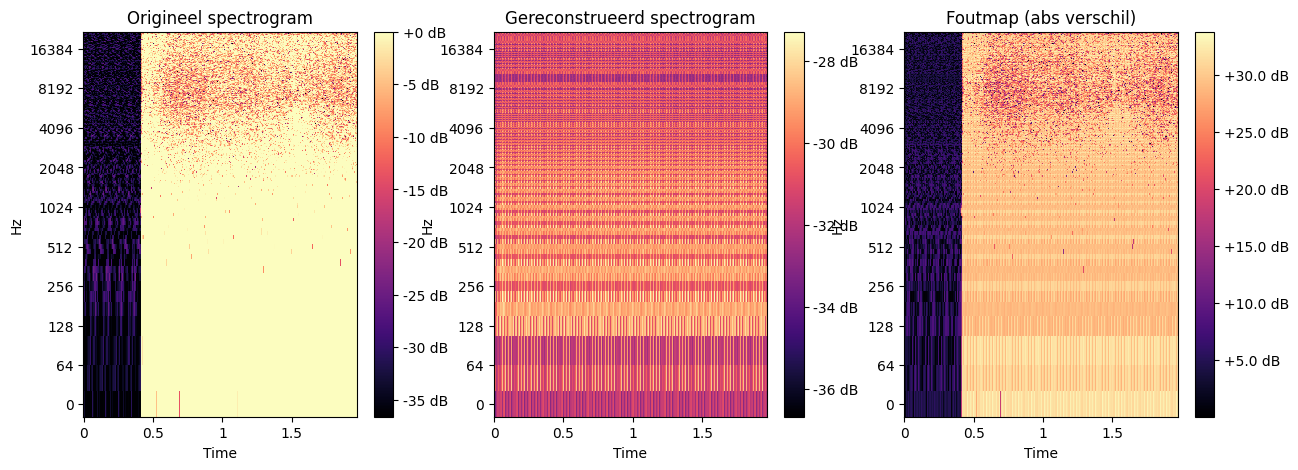

In [32]:
# Plot de drie spectrogrammen
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
librosa.display.specshow(original_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.title("Origineel spectrogram")
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 3, 2)
librosa.display.specshow(reconstructed_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.title("Gereconstrueerd spectrogram")
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 3, 3)
librosa.display.specshow(error_map, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='magma')
plt.title("Foutmap (abs verschil)")
plt.colorbar(format='%+2.1f dB')


▶️ Originele audio (gereconstrueerd vanaf spectrogram):


🎧 Geïsoleerde anomalie-frequentieband:


💾 Opslag voltooid: abnormal_wav\anomalie_frequentieband_20250707_131034.wav


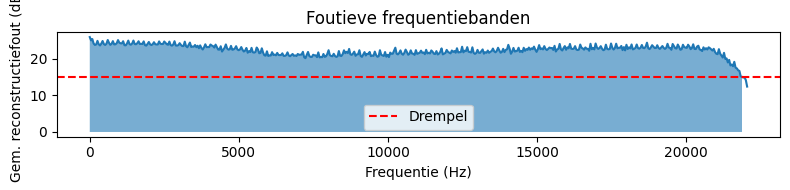

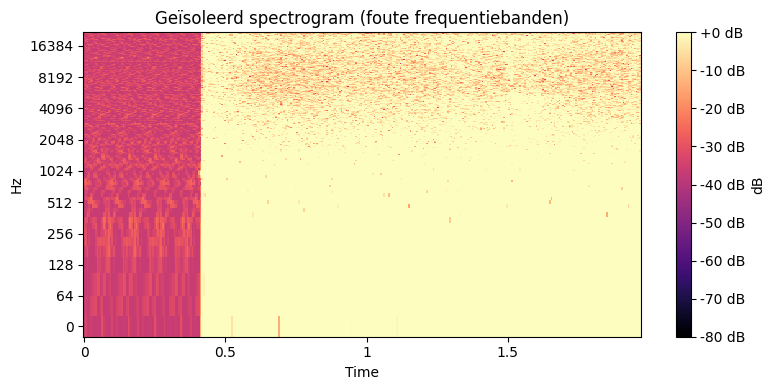

In [ ]:
from IPython.display import Audio, display
import librosa
import soundfile as sf

# === Parameters ===
threshold_db = 15.0  # bepaal zelf de gevoeligheid
output_folder = "abnormal_wav"
os.makedirs(output_folder, exist_ok=True)

# === 1. Analyseer fout per frequentieband
freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
mean_error_per_freq = np.mean(error_map, axis=1)
freq_mask = mean_error_per_freq > threshold_db
freq_mask_2d = freq_mask[:, np.newaxis]  # broadcast over tijd

# === 2. Zet originele spectrogram terug naar amplitude
original_mag = librosa.db_to_amplitude(original_db)

# === 3. Pas mask toe op originele spectrogram
masked_mag = original_mag * freq_mask_2d

# === 4. Reconstructie via Griffin-Lim
reconstructed_audio = librosa.griffinlim(masked_mag, n_fft=n_fft, hop_length=hop_length)

# === 5. Originele spectrogram → audio
original_mag_full = librosa.db_to_amplitude(original_db)
original_audio_reconstructed = librosa.griffinlim(original_mag_full, n_fft=n_fft, hop_length=hop_length)

print("▶️ Originele audio (gereconstrueerd vanaf spectrogram):")
display(Audio(original_audio_reconstructed, rate=sr))

# === 6. Toon/luister naar anomalie-frequentieband
print("🎧 Geïsoleerde anomalie-frequentieband:")
display(Audio(reconstructed_audio, rate=sr))

# === 7. Optioneel: sla ook op als .wav
isolated_path = os.path.join(output_folder, f"anomalie_frequentieband_{timestamp}.wav")
sf.write(isolated_path, reconstructed_audio, samplerate=sr)
print(f"💾 Opslag voltooid: {isolated_path}")

# === 8. Frequentie-analyse plot
plt.figure(figsize=(8, 2))
plt.plot(freqs, mean_error_per_freq)
plt.axhline(threshold_db, color='red', linestyle='--', label='Drempel')
plt.fill_between(freqs, 0, mean_error_per_freq, where=freq_mask, alpha=0.6)
plt.xlabel("Frequentie (Hz)")
plt.ylabel("Gem. reconstructiefout (dB)")
plt.title("Foutieve frequentiebanden")
plt.legend()
plt.tight_layout()
plt.show()

# === Toon gemaskeerde spectrogram (alleen foute banden)
masked_db = librosa.amplitude_to_db(masked_mag, ref=np.max)

plt.figure(figsize=(8, 4))
librosa.display.specshow(masked_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='magma')
plt.title("Geïsoleerd spectrogram (foute frequentiebanden)")
plt.colorbar(format='%+2.0f dB', label='dB')
plt.tight_layout()
plt.show()


In [ ]:
# === Extra: splits op in lage en hoge anomalieën
cutoff_freq = 1024  # Hz
cutoff_bin = np.argmax(freqs > cutoff_freq)

# Masks
low_mask = np.zeros_like(freq_mask)
low_mask[:cutoff_bin] = freq_mask[:cutoff_bin]

high_mask = np.zeros_like(freq_mask)
high_mask[cutoff_bin:] = freq_mask[cutoff_bin:]

# Pas ze toe
low_masked_mag = original_mag * low_mask[:, np.newaxis]
high_masked_mag = original_mag * high_mask[:, np.newaxis]

# Reconstructeer
low_audio = librosa.griffinlim(low_masked_mag, n_fft=n_fft, hop_length=hop_length)
high_audio = librosa.griffinlim(high_masked_mag, n_fft=n_fft, hop_length=hop_length)

# Luisteren
print("🔊 Lage frequentie-anomalieën:")
display(Audio(low_audio, rate=sr))

print("🔊 Hoge frequentie-anomalieën:")
display(Audio(high_audio, rate=sr))

🔊 Lage frequentie-anomalieën:


🔊 Hoge frequentie-anomalieën:


▶️ Originele audio:
Originele audio niet gevonden op: ../unsupervised_learning/data/UL_kantoor_2025_streamed\opname_20250707_131034.wav
🎧 Geïsoleerde anomalie-frequentieband:


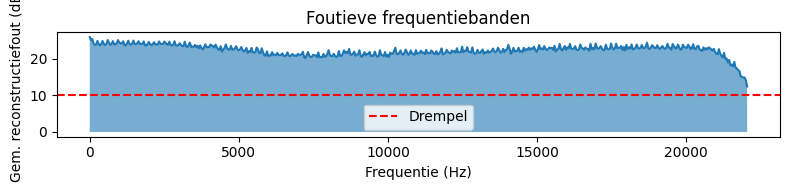

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from glob import glob
from IPython.display import Audio, display
import soundfile as sf

# === Instellingen ===
folder = "saved_spectrograms"
output_folder = "abnormal_wav"
os.makedirs(output_folder, exist_ok=True)

sr = 44100
n_fft = 1024
hop_length = 256
global_min = -80
global_max = 0
threshold_db = 10.0  # dB verschil voor anomalie
original_audio_dir = "../unsupervised_learning/data/UL_kantoor_2025_streamed"

# === 1. Zoek spectrogrambestanden ===
original_files = sorted(glob(os.path.join(folder, "original_*.npy")))
if not original_files:
    raise FileNotFoundError("Geen original_*.npy bestanden gevonden in de folder.")

# === 2. Laad het eerste paar ===
original_path = original_files[0]
timestamp = os.path.basename(original_path).replace("original_", "").replace(".npy", "")
reconstructed_path = os.path.join(folder, f"reconstructed_{timestamp}.npy")

if not os.path.exists(reconstructed_path):
    raise FileNotFoundError(f"Geen reconstructed bestand gevonden bij timestamp: {timestamp}")

original = np.load(original_path)[:513, :]
reconstructed = np.load(reconstructed_path)[:513, :]

# === 3. Denormaliseren + foutmap berekenen ===
original_db = original * (global_max - global_min) + global_min
reconstructed_db = reconstructed * (global_max - global_min) + global_min
error_map = np.abs(original_db - reconstructed_db)

# === 4. Analyseer fout per frequentieband ===
freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
mean_error_per_freq = np.mean(error_map, axis=1)
freq_mask = mean_error_per_freq > threshold_db
freq_mask_2d = freq_mask[:, np.newaxis]

# === 5. Mask toepassen op origineel spectrogram (amplitude)
original_mag = librosa.db_to_amplitude(original_db)
masked_mag = original_mag * freq_mask_2d

# === 6. Reconstructie naar audio
reconstructed_audio = librosa.griffinlim(masked_mag, n_fft=n_fft, hop_length=hop_length)

# === 7. Speel originele audio af
audio_file_path = os.path.join(original_audio_dir, f"opname_{timestamp}.wav")
print("▶️ Originele audio:")
if os.path.exists(audio_file_path):
    y, _ = librosa.load(audio_file_path, sr=sr)
    display(Audio(y, rate=sr))
else:
    print(f"Originele audio niet gevonden op: {audio_file_path}")

# === 8. Speel anomalie-frequentieband af
print("🎧 Geïsoleerde anomalie-frequentieband:")
display(Audio(reconstructed_audio, rate=sr))

# === 9. Plot frequenties met hoge fout
plt.figure(figsize=(8, 2))
plt.plot(freqs, mean_error_per_freq)
plt.axhline(threshold_db, color='red', linestyle='--', label='Drempel')
plt.fill_between(freqs, 0, mean_error_per_freq, where=freq_mask, alpha=0.6)
plt.xlabel("Frequentie (Hz)")
plt.ylabel("Gem. reconstructiefout (dB)")
plt.title("Foutieve frequentiebanden")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf

# Direct converteren naar TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(vae)  # Gebruik je VAE-model direct
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

tflite_model = converter.convert()

# Opslaan als .tflite-bestand
with open("models/vae_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model succesvol opgeslagen als vae_model.tflite")


Dit zegt natuurlijk niks over hoe goed het model werkt, want het is live testing. Maar deze aanpak is redelijk succesvol. Wanneer ik in mijn handen klap of tegen de microfoon tik dan ziet hij deze als een abnormaliteit.

---

## Deployment
**Conclusie:**
- De huidige aanpak lijkt hoopvol en deze moeten we testen op de Raspberry Pi 

**Volgende Stappen:**
- Data Augmentatie toepassen
- Beter idee krijgen hoe de data eruit moet zien voor dit model
- Kijken welke aanpassesn een positief gevolg heeft voor het resultaat